# 6. Named entity recognition

It can be very interesting to use Named Entity Recongition and Named Entity Linking for founding entities in our dataset and connect them to each other. For example what we can do is to create a character co-occurence graph, or also identifying the most important places in the world of Attack on Titan.

**Table of contents:**
- NER:
  - en_core_web_sm
  - en_core_web_trf
- Characters co-occurence graph:
  - Home-made vocabulary of character
  - NEL
- Bridge with Sentiment Analysis and Community detection 
  - Characters Sentiment
  - Characters per Community
  - Characters Sentiment per Community

In [ ]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import networkx as nx
import spacy
from spacy import displacy
from collections import Counter, defaultdict
from pprint import pprint
import spacy
import spacy_transformers
import re
from bs4 import BeautifulSoup
import spotlight
import requests
from itertools import combinations
import ast
import numpy as np

# load
df_ending = pd.read_csv('../data/aot_ending.csv')
df_ending['created_utc'] = pd.to_datetime(df_ending['created_utc'])
df_comments = pd.read_csv('../data/comments_graph_ending_final.csv')
df_comments['created_utc'] = pd.to_datetime(df_comments['created_utc'])
df_communities = pd.read_csv('../data/communities.csv')
G = pickle.load(open('../data/comments_graph.pickle', 'rb'))

## NER - Named Entity recognition

### en_core_web_sm

English pipeline optimized for CPU: [en_core_web_sm](https://spacy.io/models/en#en_core_web_sm) 

Pipeline:

```mermaid
flowchart LR
    tok2vec --> tagger --> parser --> attribute_ruler --> lemmatizer --> ner
    
```

First we try a lightweight and small model for NER.

In [3]:
ner_model = spacy.load("en_core_web_sm")

def extract_entities(text, ner_model):
    doc = ner_model(text)
    return [(X.text, X.label_) for X in doc.ents]

In [4]:
df_comments['entities'] = df_comments['text_comment'].apply(lambda x: extract_entities(x, ner_model))
df_comments['entities'][0:5]

0                 [(Armin Mikasa, PERSON), (Sea, LOC)]
1       [(this season, DATE), (the next season, DATE)]
2                                   [(Marley, PERSON)]
3                                    [(one, CARDINAL)]
4    [(Jean, PERSON), (Armin, PERSON), (end of seas...
Name: entities, dtype: object

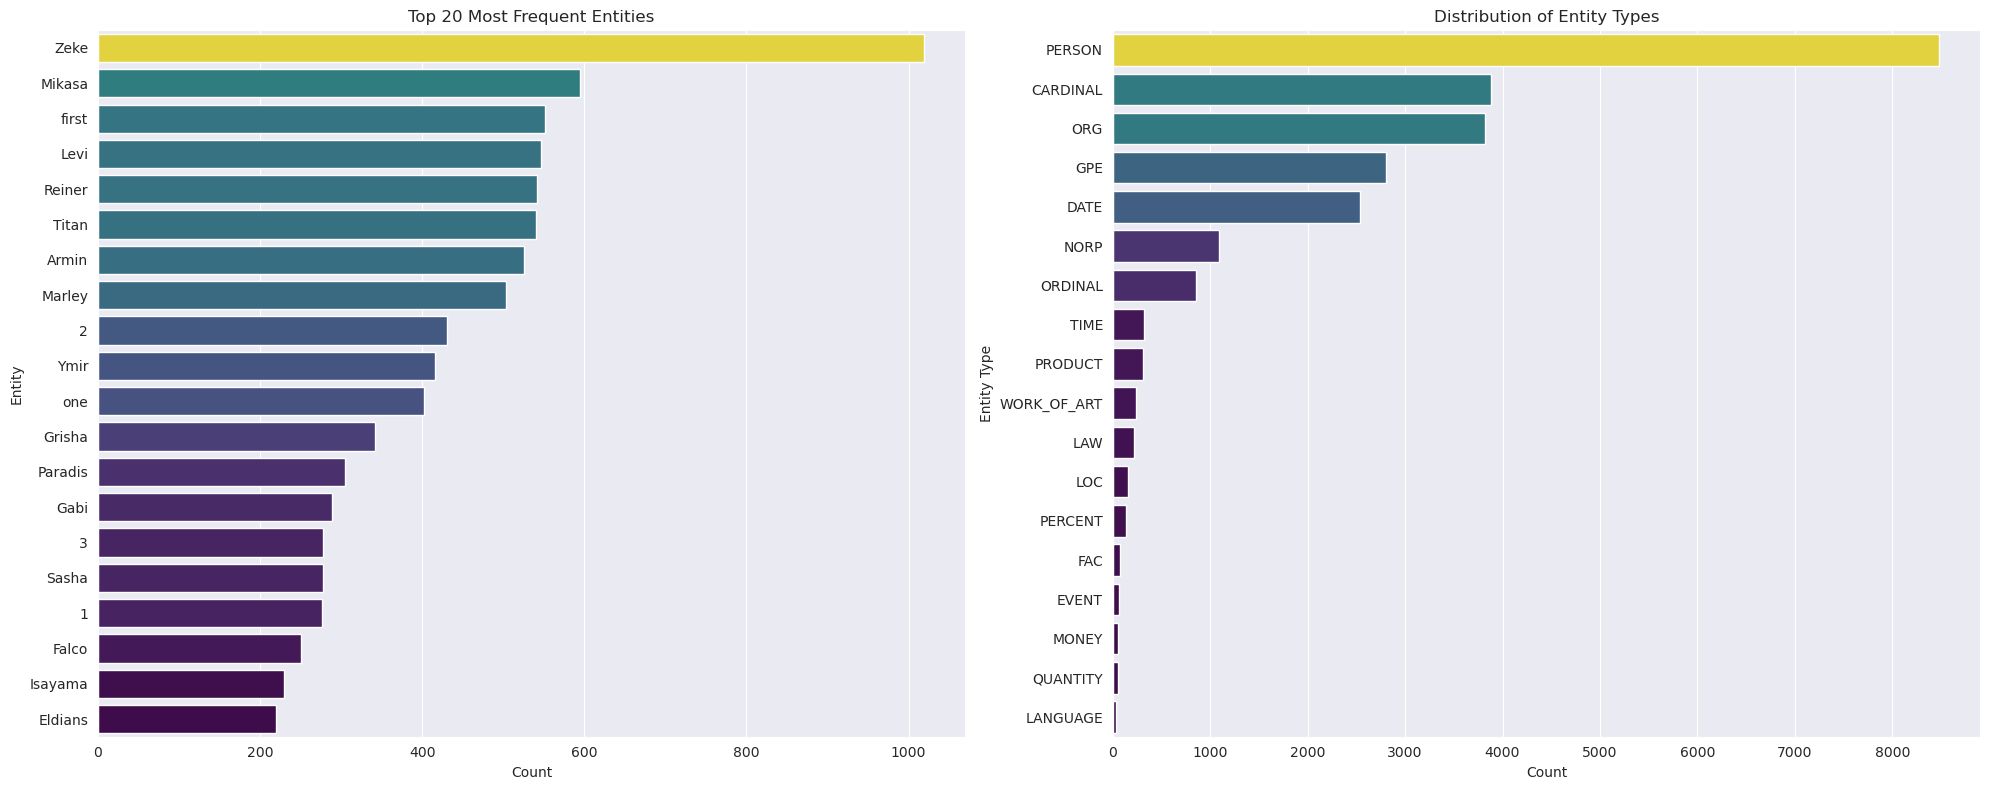

In [ ]:
# data for distribution of entities
all_entities = [ent for sublist in df_comments['entities'] for ent in sublist]
entity_texts = [e[0] for e in all_entities]
most_common_entities = Counter(entity_texts).most_common(20)
labels, counts = zip(*most_common_entities)

# data for distribution of entity types
entity_labels = [e[1] for e in all_entities]
label_counts = Counter(entity_labels)
sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)
labels_dist, counts_dist = zip(*sorted_labels)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Top 20 Most Frequent Entities
sns.barplot(x=list(counts), y=list(labels), orient='h', palette='viridis', hue=list(counts), legend=False, ax=ax1)
ax1.set_title("Top 20 Most Frequent Entities")
ax1.set_xlabel("Count")
ax1.set_ylabel("Entity")

# Plot 2: Distribution of Entity Types
sns.barplot(x=list(counts_dist), y=list(labels_dist), orient='h', palette='viridis', hue=list(counts_dist), legend=False, ax=ax2)
ax2.set_title("Distribution of Entity Types")
ax2.set_xlabel("Count")
ax2.set_ylabel("Entity Type")

plt.tight_layout()
plt.show()


In [6]:
# Group entities by their labels and count occurrences
entity_label_counts = {}

for entity_text, entity_label in all_entities:
    if entity_label not in entity_label_counts:
        entity_label_counts[entity_label] = Counter()
    entity_label_counts[entity_label][entity_text] += 1

LABELS = ['PERSON', 'LOC', 'GPE', 'ORG', 'NORP', 'PRODUCT', 'WORK_OF_ART', 'FAC']

# Print top entities for each category
for label in LABELS:
    if label in entity_label_counts:
        print(f"\n=== {label} ===")
        top_entities = entity_label_counts[label].most_common(10)
        for entity, count in top_entities:
            print(f"{entity}: {count}")


=== PERSON ===
Zeke: 1019
Levi: 546
Reiner: 537
Marley: 450
Armin: 420
Ymir: 416
Grisha: 342
Paradis: 298
Sasha: 230
Historia: 195

=== LOC ===
Paradise: 36
the Attack Titan: 27
Attack Titan: 17
Earth: 8
Island: 6
Attack: 5
Europe: 5
Euthanasia: 4
Paradise Island: 3
Shiganshina: 3

=== GPE ===
Mikasa: 581
Titan: 540
Gabi: 254
Isayama: 223
titan: 109
mikasa: 69
Manga: 60
Sasha: 44
Erens: 43
Marley: 39

=== ORG ===
CGI: 217
OST: 197
AOT: 193
AoT: 193
Falco: 173
Eren's: 114
Eren: 63
Eren’s: 62
Pieck: 62
Tybur: 58

=== NORP ===
Eldians: 218
Titans: 217
Eldian: 113
Japanese: 52
Marleyans: 46
japanese: 21
Reiss: 20
Yeagerists: 15
Jaegerists: 15
creepy: 15

=== PRODUCT ===
CG: 78
Armin: 67
Hange: 16
S4: 14
Founder: 11
YouTube: 8
Ackerman: 4
Attack Titans: 4
Lara: 4
F: 3

=== WORK_OF_ART ===
Gabi: 10
The Final Season: 5
Floch: 5
Opening: 5
The Rumbling: 4
Gabi and Eren: 4
Season 1: 3
Season 2: 3
Season 3 Part 1: 3
Season 3 Part 2: 3

=== FAC ===
104th: 8
Attack: 7
intro: 5
Ackerman: 3
Lelouch

In [7]:
# Find occurrences of 'eren' in the text_comment column (case-insensitive)
eren_occurrences = df_comments['text_comment'].str.contains('eren', case=False, na=False)
print(f"Number of comments containing 'eren': {eren_occurrences.sum()}")

eren_count = sum([True if ent[0].lower() == 'eren' else False for ent in all_entities])
print(f"Number of entities named 'eren': {eren_count}")

Number of comments containing 'eren': 3038
Number of entities named 'eren': 191


This small model is having difficulty correctly classifying the entities from this fictional work. For example:
- Eren isn't recognized from the model `en_core_web_sm`
- Marley, Paradis -> PERSON, should be LOC
- Mikasa, Gabi Isayama, Sasha -> GPE, should be PERSON
- ORG are almost all of them wrong
- Instead we obtained good results for NORP, in which Eldians and Marleyans are correctly classified

Notes: Marley is a city and Paradis is an island. The corresponding inhabitants are Marleyans and Eldians.

### en_core_web_trf
English transformer pipeline `(Transformer(name=‘roberta-base’, piece_encoder=‘byte-bpe’, stride=104, type=‘roberta’, width=768, window=144, vocab_size=50265)). `: [en_core_web_trf](https://spacy.io/models/en#en_core_web_trf)

Pipeline:

```mermaid
flowchart LR
    transformer --> tagger --> parser --> attribute_ruler --> lemmatizer --> ner

```

We use a fine-tuned *"roberta-base"* model for doing the task of NER

In [10]:
# load bert based NER model
ner_model_tr = spacy.load("en_core_web_trf")
df_comments['entities'] = df_comments['text_comment'].apply(lambda x: extract_entities(x, ner_model_tr))
df_comments['entities'][0:5]

0    [(Armin Mikasa, PERSON), (Eren, PERSON), (Sea,...
1    [(this season, DATE), (previous seasons, DATE)...
2                                   [(Marley, PERSON)]
3                                                   []
4    [(Jean, PERSON), (Armin, PERSON), (season 1, D...
Name: entities, dtype: object

In [10]:
# after a first analysis we see that both eren and Eren are used in the comments
# so we store also a copy of the entities in lowercase
df_comments['entities_lowercase'] = df_comments['entities'].apply(
    lambda ents: [(ent[0].lower(), ent[1]) for ent in ents]
)
flat_entities = [e[0] for sublist in df_comments['entities_lowercase'] for e in sublist]

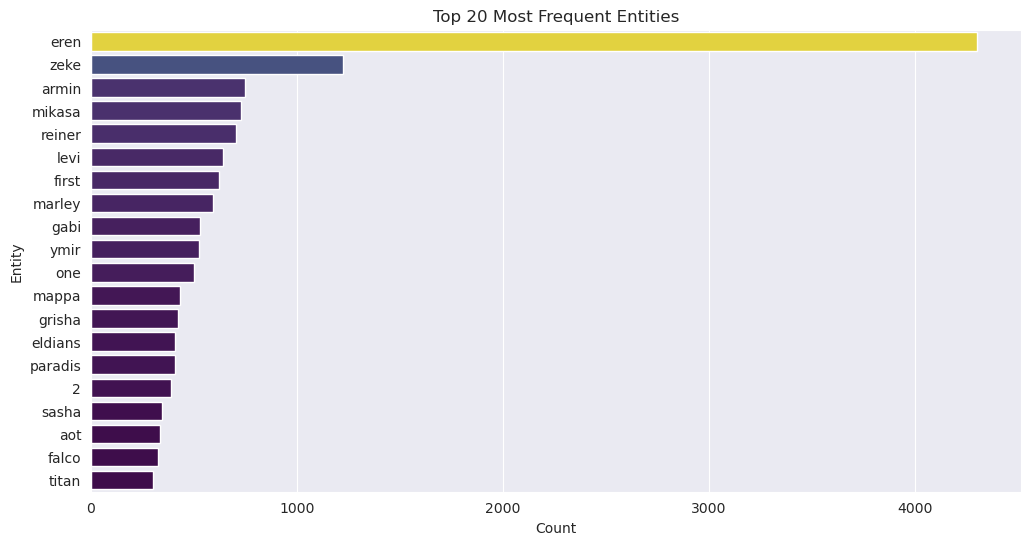

In [11]:
# Flatten list of entities
all_entities = [ent for sublist in df_comments['entities_lowercase'] for ent in sublist]
entity_texts = [e[0] for e in all_entities]

# Most common entities
most_common_entities = Counter(entity_texts).most_common(20)
labels, counts = zip(*most_common_entities)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(labels), orient='h', palette='viridis', hue=list(counts), legend=False)
plt.title("Top 20 Most Frequent Entities")
plt.xlabel("Count")
plt.ylabel("Entity")
plt.show()

In [12]:
# Group entities by their labels and count occurrences
entity_label_counts = {}

for entity_text, entity_label in all_entities:
    if entity_label not in entity_label_counts:
        entity_label_counts[entity_label] = Counter()
    entity_label_counts[entity_label][entity_text] += 1

LABELS = ['PERSON', 'LOC', 'GPE', 'ORG', 'NORP', 'PRODUCT', 'WORK_OF_ART', 'FAC']

# Print top entities for each category
for label in LABELS:
    if label in entity_label_counts:
        print(f"\n=== {label} ===")
        top_entities = entity_label_counts[label].most_common(10)
        for entity, count in top_entities:
            print(f"{entity}: {count}")


=== PERSON ===
eren: 4282
zeke: 1220
armin: 736
mikasa: 722
reiner: 695
levi: 636
gabi: 512
ymir: 485
marley: 470
grisha: 418

=== LOC ===
paradis: 109
paradis island: 40
paradise: 35
titan: 17
marley: 16
historia: 7
earth: 7
paradise island: 6
eren: 6
europe: 5

=== GPE ===
marley: 72
paradis: 60
ymir: 31
japan: 24
liberio: 20
shiganshina: 13
saudi arabia: 5
us: 4
paradis island: 4
titanfolk: 4

=== ORG ===
mappa: 231
aot: 92
titans: 67
wit: 65
paradis: 63
crunchyroll: 51
hulu: 46
snk: 37
scouts: 36
va: 36

=== NORP ===
eldians: 407
titans: 187
eldian: 169
marleyans: 66
marleyan: 57
japanese: 54
titan: 43
paradis: 28
jaegerists: 15
ackermans: 14

=== PRODUCT ===
titan: 150
the attack titan: 47
2volt: 38
s4: 31
attack titan: 28
cgi: 27
warhammer: 27
youseebiggirl: 25
s3: 24
s2: 23

=== WORK_OF_ART ===
aot: 203
attack on titan: 102
historia: 34
rumbling: 31
manga: 26
warhammer: 25
game of thrones: 24
one piece: 21
paths: 19
wit: 18

=== FAC ===
paradis: 13
fort salta: 6
historia: 4
par


---

## Characters co-occurence graph

First we can plot as a heatmap the co-occurence matrix of the most frequent entities in our dataset. Two entities co-occurs when they appear in the same comment.

Later we are going to plot a co-occurence graph of the characters:

$$G = (N, E)$$
where:
- $N = \{\text{characters}\} = \{c_1, c_2, \cdots, c_n\}$ is the set of nodes, each representing a unique character.
- $E = \{\text{co-occurrences}\} = \{(c_i, c_j, w_{ij})\}$ is the set of weighted edges, where an edge exists between characters $c_i$ and $c_j$ if they are mentioned together in at least one comment .

The edge weight $w_{ij} \in \N$ indicates the number of distinct comments in which both characters $c_i$​ and $c_j$ are mentioned together.

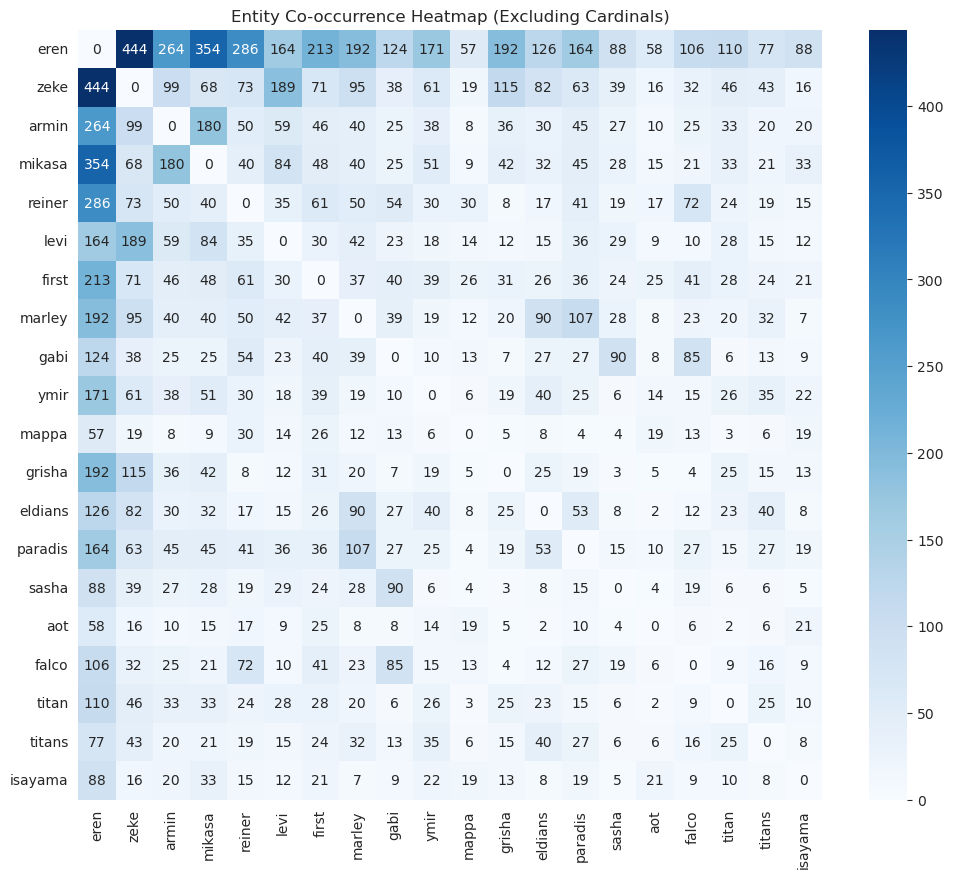

In [ ]:
# Build co-occurrence matrix, excluding CARDINAL entities
co_matrix = defaultdict(lambda: defaultdict(int))
for ents in df_comments['entities_lowercase']:
    # Filter out CARDINAL entities
    names = list(set([e[0] for e in ents if e[1] != 'CARDINAL']))
    for a, b in combinations(names, 2):
        co_matrix[a][b] += 1
        co_matrix[b][a] += 1

# Convert to DataFrame (limit to top N, excluding cardinals)
entity_texts_no_cardinals = [e[0] for e in all_entities if e[1] != 'CARDINAL']
most_common_entities_no_cardinals = Counter(entity_texts_no_cardinals).most_common(20)
top_entities = [e[0] for e in most_common_entities_no_cardinals]
matrix = pd.DataFrame([[co_matrix[a][b] for b in top_entities] for a in top_entities],
                      index=top_entities, columns=top_entities)

plt.figure(figsize=(12, 10))
sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Entity Co-occurrence Heatmap (Excluding Cardinals)")
plt.show()


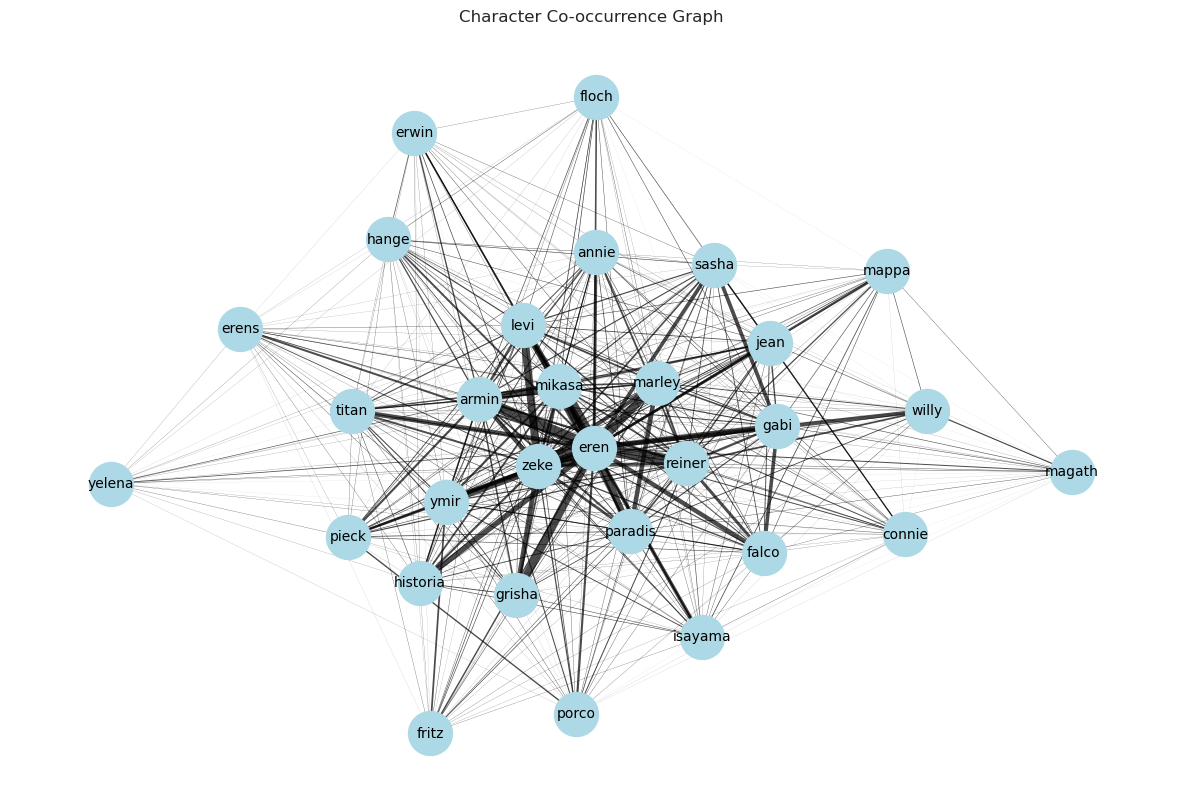

In [14]:
G_char = nx.Graph()

# edges for co-occurring character pairs, using the count as the weight
all_characters = [e[0] for e in all_entities if e[1] == 'PERSON']
top_characters = [e[0] for e in Counter(all_characters).most_common(30)]
for a in top_characters:
    for b in top_characters:
        if a != b and co_matrix[a][b] > 0:
            G_char.add_edge(a, b, weight=co_matrix[a][b])

# Draw the graph
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G_char, k=0.5, seed=42)
edges = G_char.edges()
weights = [G_char[u][v]['weight'] for u, v in edges] ### <-- weights for edges
nx.draw_networkx_nodes(G_char, pos, node_size=1000, node_color='lightblue')
nx.draw_networkx_edges(G_char, pos, edgelist=edges, width=[w * 0.03 for w in weights], alpha=0.7)
nx.draw_networkx_labels(G_char, pos, font_size=10, font_family="sans-serif")
plt.title("Character Co-occurrence Graph")
plt.axis("off")
plt.show()


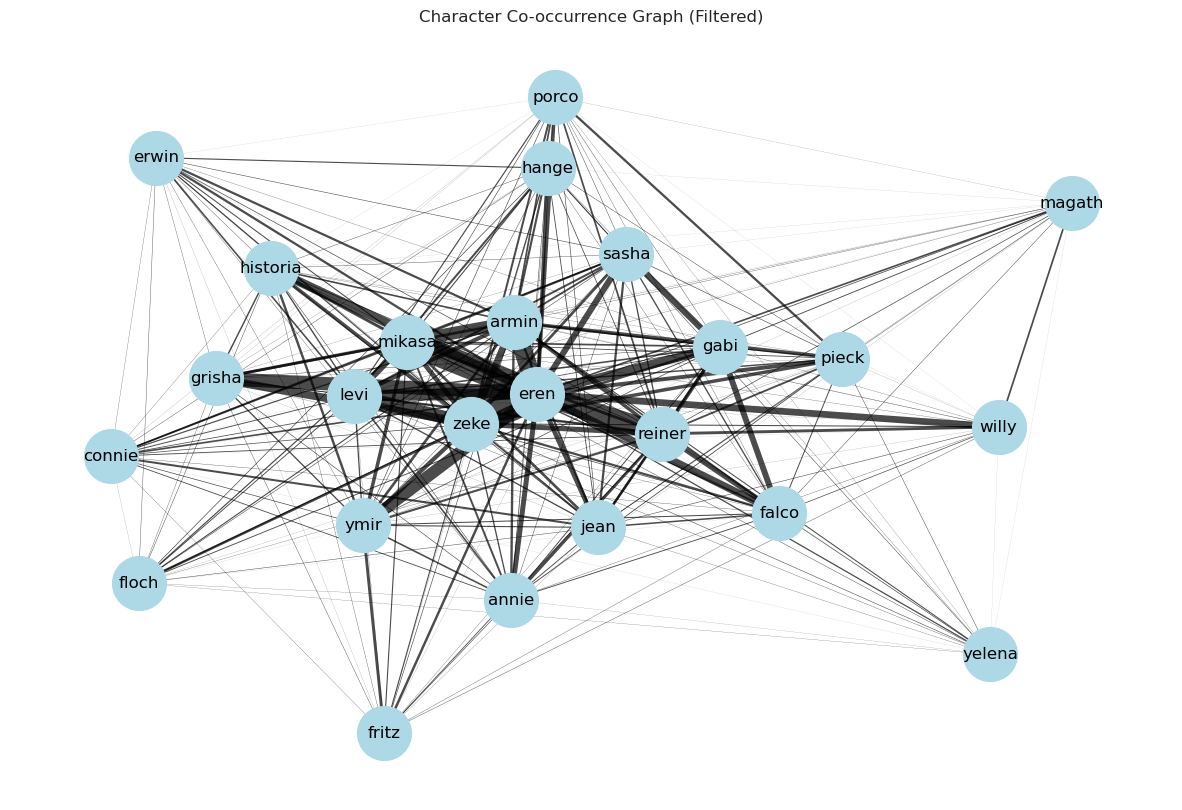

In [15]:
# By manual inspection we remove some entities wich are not characters
entities_to_remove = [
    'mappa', 'titan', 'erens', 'paradis', 'isayama', 'marley'
]
# Remove specified entities from the graph
for entity in entities_to_remove:
    if entity in G_char:
        G_char.remove_node(entity)

# Draw the updated graph
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G_char, k=0.5, seed=42)
edges = G_char.edges()
weights = [G_char[u][v]['weight'] for u, v in edges]
nx.draw_networkx_nodes(G_char, pos, node_size=1500, node_color='lightblue')
nx.draw_networkx_edges(G_char, pos, edgelist=edges, width=[w * 0.05 for w in weights], alpha=0.7)
nx.draw_networkx_labels(G_char, pos, font_size=12, font_family="sans-serif")
plt.title("Character Co-occurrence Graph (Filtered)")
plt.axis("off")
plt.show()

### Home-made vocabulary of character

Since we are dealing with a very specific topic, we can try to crawl from wikipedia de list of characters and find the matching of such strings within the text.

Take from wikipedia the list of characters with the REST API: [AoT_characters](https://en.wikipedia.org/wiki/List_of_Attack_on_Titan_characters) 

In [16]:
# URL of the Wikipedia page containing the list of Attack on Titan characters
url = "https://en.wikipedia.org/wiki/List_of_Attack_on_Titan_characters"

# Send a GET request to the URL
response = requests.get(url)
response.raise_for_status()  # Raise exception for HTTP errors

soup = BeautifulSoup(response.text, 'html.parser')
print(soup.prettify())

<!DOCTYPE html>
<html class="client-nojs vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-limited-width-content-enabled vector-feature-custom-font-size-clientpref-1 vector-feature-appearance-pinned-clientpref-1 vector-feature-night-mode-enabled skin-theme-clientpref-day vector-sticky-header-enabled vector-toc-available" dir="ltr" lang="en">
 <head>
  <meta charset="utf-8"/>
  <title>
   List of Attack on Titan characters - Wikipedia
  </title>
  <script>
   (function(){var className="client-js vector-feature-language-in-header-enabled vector-feature-language-in-main-page-header-disabled vector-feature-page-tools-pinned-disabled vector-feature-toc-pinned-clientpref-1 vector-feature-main-menu-pinned-disabled vector-feature-limited-width-clientpref-1 vector-feature-li

In [17]:
# extract all occurrences of characters
# The pattern looks for: <span class="vanchor"><span id="Character_Name"></span>
# (found via manual inspection)
pattern = r'<span class="vanchor"><span id="([^"]+)"></span>'
matches = re.findall(pattern, response.text)

# from manual inspection we have seen a problem with Historia
historia_matches = [(i, match) for i, match in enumerate(matches) if 'Historia' in match]
print(f"Matches containing 'Historia': {historia_matches}")
matches[historia_matches[0][0]] = "Historia_Reiss"

for name in matches:
    print(name)

Matches containing 'Historia': [(11, '&#39;&#39;&#39;Historia_Reiss&#39;&#39;&#39;')]
Eren_Yeager
Mikasa_Ackerman
Armin_Arlert
Reiner_Braun
Darius_Zackly
Keith_Shadis
Jean_Kirstein
Marco_Bott
Connie_Springer
Sasha_Blouse
Krista_Lenz
Historia_Reiss
Ymir
Floch_Forster
Erwin_Smith
Hange_Zoë
Mike_Zacharius
Moblit_Berner
Ilse_Langnar
Nanaba
Louise
Holger
Wim
Levi_Ackerman
Eld_Jinn
Oluo_Bozado
Petra_Ral
Günther_Schultz
Hannes
Dot_Pixis
Rico_Brzenska
Nile_Dok
Marlowe_Freudenberg
Hitch_Dreyse
Boris_Feulner
Captain_Kenny_Ackerman
Traute_Carven
Djel_Sanes
Fritz
Rod_Reiss
Frieda_Reiss
Grisha_Yeager
Carla_Yeager
Minister_Nick
Dimo_Reeves
Kaya
Ymir_Fritz
Karl_Fritz
Founding_Titan
Attack_Titan
Colossus_Titan
Armored_Titan
Female_Titan
Beast_Titan
Jaw_Titan
Cart_Titan
War_Hammer_Titan
Sonny_and_Bean
Calvi
Theo_Magath
Zeke_Yeager
Bertholdt_Hoover
Annie_Leonhart
Marcel_Galliard
Porco_Galliard
Pieck_Finger
Gabi_Braun
Falco_Grice
Colt_Grice
Willy_Tybur
Lara_Tybur
Mr._Yeager
Mrs._Yeager
Faye_Yeager
Tom_Ks

In [32]:
# Extract first names from the matches
names = [name.split("_")[0] for name in matches]
print(f"Total names extracted: {len(names)}")
print(f"Unique names: {len(set(names))}")
print(f"Are all names unique? {len(names) == len(set(names))}")

# Show duplicate names if any
if len(names) != len(set(names)):
    name_counts = Counter(names)
    duplicates = [name for name, count in name_counts.items() if count > 1]
    print(f"Duplicate names: {duplicates}")
    
    # Show which full names correspond to duplicates
    for duplicate in duplicates:
        full_names = [match for match in matches if match.split("_")[0] == duplicate]
        print(f"'{duplicate}' appears in: {full_names}")

set_characters = set()
lower_to_original = {}
for full_name in matches:
    lower_name = full_name.split("_")[0].lower()
    set_characters.add(lower_name)
    # this two unfortunately are going to be forgotten
    if full_name not in ['Eren_Kruger', 'Ymir_Fritz']:
        lower_to_original[lower_name] = full_name

Total names extracted: 84
Unique names: 82
Are all names unique? False
Duplicate names: ['Eren', 'Ymir']
'Eren' appears in: ['Eren_Yeager', 'Eren_Kruger']
'Ymir' appears in: ['Ymir', 'Ymir_Fritz']


Using just the names is going to be a good approximation for our matching model. Since the duplicates are from older (in the story of the manga) and secondary characters. 

Ther are also a bit of problems with for example *Mr._Yeager* and *Mrs.Yeager* (but no one call them in that way) and also it can be not very reasonable to have *Colossus_Titan*, *Armored_Titan*, *Female_Titan*, *Beast_Titan*.. as characters, but thats really a minor problem.

In [19]:
def find_character_names(text, character_set):
    """Find character names from the set that appear in the text (case-insensitive)"""
    if pd.isna(text):
        return []
    
    text_lower = text.lower()
    found_characters = []
    
    for character in character_set:
        if character in text_lower:
            found_characters.append(character)
    
    return found_characters

# Add the column with character names found in each comment
df_comments['character_names'] = df_comments['text_comment'].apply(
    lambda x: find_character_names(x, set_characters)
)
df_comments['character_names'][0:5]


0         [eren, mikasa, armin]
1                            []
2                         [war]
3                            []
4    [eren, jean, armin, floch]
Name: character_names, dtype: object

In [20]:
co_matrix = defaultdict(lambda: defaultdict(int))
for characters in df_comments['character_names']:
    for a, b in combinations(characters, 2):
        co_matrix[a][b] += 1
        co_matrix[b][a] += 1

# Convert to DataFrame (limit to top N, excluding cardinals)
all_characters = [ent for sublist in df_comments['character_names'] for ent in sublist]
top_characters = [e[0] for e in Counter(all_characters).most_common(30)]
matrix = pd.DataFrame([[co_matrix[a][b] for b in top_characters] for a in top_characters],
                      index=top_characters, columns=top_characters)


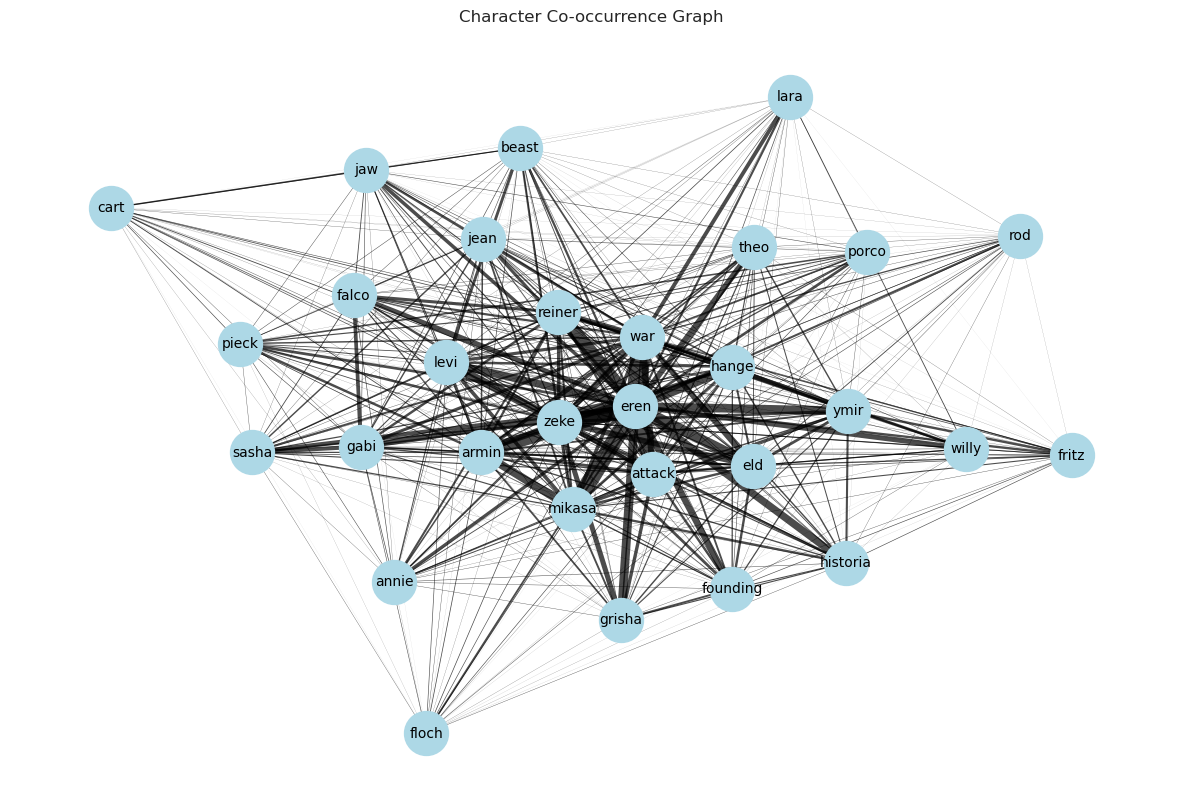

In [21]:
G_char = nx.Graph()

# edges for co-occurring character pairs, using the count as the weight
for a in top_characters:
    for b in top_characters:
        if a != b and co_matrix[a][b] > 0:
            G_char.add_edge(a, b, weight=co_matrix[a][b])

# Draw the graph
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G_char, k=0.5, seed=42)
edges = G_char.edges()
weights = [G_char[u][v]['weight'] for u, v in edges] ### <-- weights for edges
nx.draw_networkx_nodes(G_char, pos, node_size=1000, node_color='lightblue')
nx.draw_networkx_edges(G_char, pos, edgelist=edges, width=[w * 0.03 for w in weights], alpha=0.7)
nx.draw_networkx_labels(G_char, pos, font_size=10, font_family="sans-serif")
plt.title("Character Co-occurrence Graph")
plt.axis("off")
plt.show()

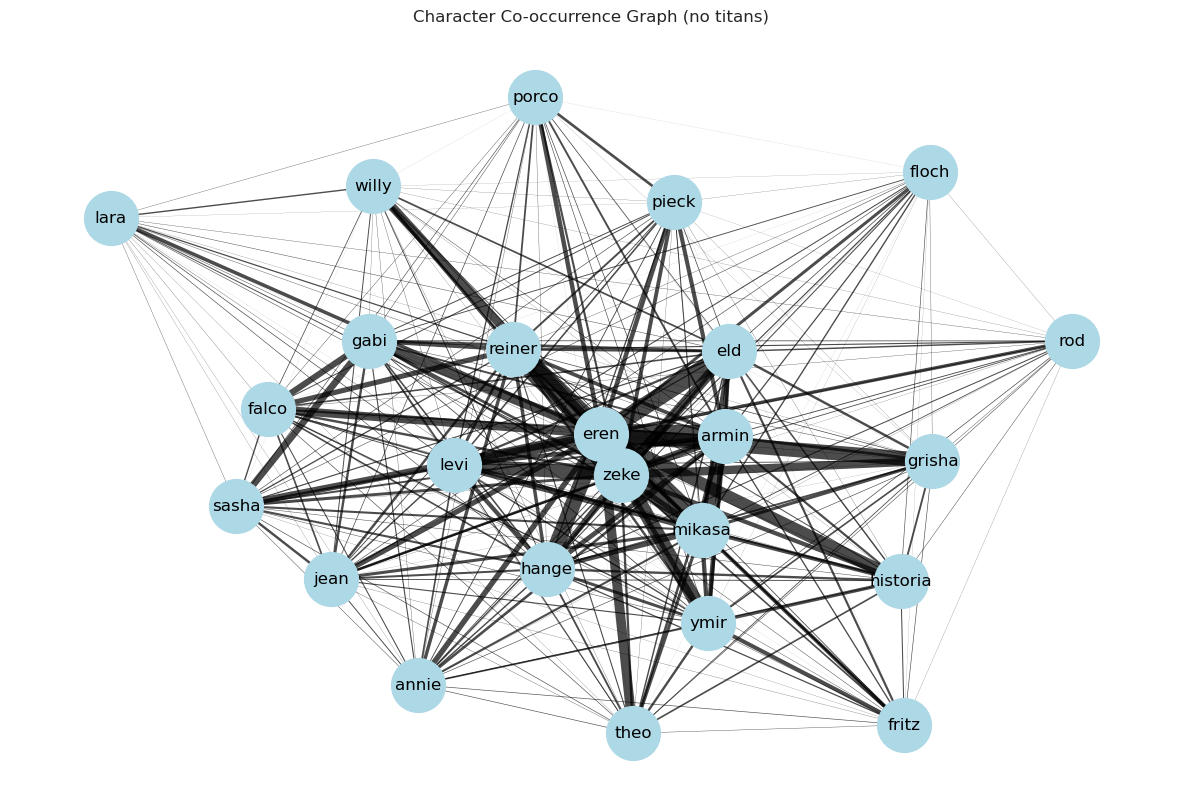

In [22]:
# by removing the names of the titans
entities_to_remove = [
    'war', 'founding', 'cart', 'jaw', 'beast', 'marley', 'attack'
]
# Remove specified entities from the graph
for entity in entities_to_remove:
    if entity in G_char:
        G_char.remove_node(entity)

# Draw the updated graph
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(G_char, k=0.5, seed=42)
edges = G_char.edges()
weights = [G_char[u][v]['weight'] for u, v in edges]
nx.draw_networkx_nodes(G_char, pos, node_size=1500, node_color='lightblue')
nx.draw_networkx_edges(G_char, pos, edgelist=edges, width=[w * 0.05 for w in weights], alpha=0.7)
nx.draw_networkx_labels(G_char, pos, font_size=12, font_family="sans-serif")
plt.title("Character Co-occurrence Graph (no titans)")
plt.axis("off")
plt.show()

### NEL - Named Entity Linking

We performe Named Entity Linking to associated our detected entities to real entities in the **dbpedia** knowledge graph

In [91]:
char_lowercase = [node for node in G_char.nodes()]
char_og_names = [lower_to_original[node].replace("_", " ") for node in char_lowercase if node in lower_to_original]

def get_dbpedia_url(character_name):
    # API endpoint
    url = "https://api.dbpedia-spotlight.org/en/annotate"
    headers = {'Accept': 'application/json'}
    data = {
        'text': character_name,
        'confidence': 0.5
    }

    response = requests.post(url, headers=headers, data=data)

    # extract annotations from the response
    if response.status_code == 200:
        annotations = response.json().get("Resources", [])
    else:
        print(f"Request Error: {response.status_code}")
        annotations = []
        
    return annotations

# Get DBpedia URLs for each character
dbpedia_urls = {}
for character in char_og_names:
    annotations = get_dbpedia_url(character)
    if annotations:
        dbpedia_urls[character] = annotations[0]["@URI"]  # Store the first annotation URL
# Print the DBpedia URLs
for character, url in dbpedia_urls.items():
    print(f"{character:<15}: {url}")


Eren Yeager    : http://dbpedia.org/resource/Eren_Yeager
Reiner Braun   : http://dbpedia.org/resource/Fritz_Reiner
Eld Jinn       : http://dbpedia.org/resource/Jinn
Ymir           : http://dbpedia.org/resource/Ymir
Sasha Blouse   : http://dbpedia.org/resource/Sasha_Valentine
Porco Galliard : http://dbpedia.org/resource/Galliard
Lara Tybur     : http://dbpedia.org/resource/House_of_Lara
Floch Forster  : http://dbpedia.org/resource/Ray_Forster



---

## Bridge with Sentiment Analysis and Community detection 

### Characters per community

We look at the distribution of characters per community

In [ ]:
# ### LOAD
# df_comments = pd.read_csv('../data/comments_graph_with_entities.csv')
# df_comments['created_utc'] = pd.to_datetime(df_comments['created_utc'])
# # convert string representations back to Python objects
# # ex: "['(Eren, PERSON)', '(Mikasa, PERSON)']" to [('Eren', 'PERSON'), ('Mikasa', 'PERSON')]
# df_comments['entities'] = df_comments['entities'].apply(ast.literal_eval)
# df_comments['entities_lowercase'] = df_comments['entities_lowercase'].apply(ast.literal_eval)
# df_comments['character_names'] = df_comments['character_names'].apply(ast.literal_eval)

In [3]:
df_communities = pd.read_csv('../data/communities.csv')

In [4]:
# Analyze character presence in each community
community_character_analysis = {}

# Get unique communities
communities = df_communities['infomap_community'].unique()

for community_id in communities:
    # Get nodes in this community
    nodes_in_comm = df_communities[df_communities['infomap_community'] == community_id]['node'].tolist()
    
    # Filter comments from users in this community
    community_comments = df_comments[df_comments['parent'].isin(nodes_in_comm)]
    
    # Collect all character mentions from this community
    all_characters_in_comm = []
    for ent_list in community_comments['entities_lowercase']:
        for char_list, tag in ent_list:
            # Append character names to the list if they are of type 'PERSON'
            if tag == 'PERSON':
                all_characters_in_comm.append(char_list)

    # Count character frequencies
    character_counts = Counter(all_characters_in_comm)
    
    # Store results
    community_character_analysis[community_id] = {
        'num_users': len(nodes_in_comm),
        'num_comments': len(community_comments),
        'character_counts': character_counts,
        'top_characters': character_counts.most_common(10)
    }

# Display results for each community
for community_id, analysis in community_character_analysis.items():
    print(f"\n=== Community {community_id} ===")
    print(f"Users: {analysis['num_users']}")
    print(f"Comments: {analysis['num_comments']}")
    print("Top 10 characters:")
    for char, count in analysis['top_characters']:
        print(f"  {char}: {count}")



=== Community 6 ===
Users: 175
Comments: 218
Top 10 characters:
  eren: 54
  armin: 14
  mikasa: 14
  marley: 12
  historia: 10
  zeke: 9
  grisha: 6
  floch: 5
  levi: 5
  erwin: 5

=== Community 0 ===
Users: 6357
Comments: 9975
Top 10 characters:
  eren: 3018
  zeke: 1062
  reiner: 572
  levi: 544
  armin: 492
  gabi: 475
  marley: 416
  mikasa: 359
  sasha: 317
  grisha: 315

=== Community 2 ===
Users: 726
Comments: 890
Top 10 characters:
  eren: 366
  isayama: 87
  mikasa: 83
  ymir: 75
  armin: 52
  historia: 49
  zeke: 41
  reiner: 30
  grisha: 21
  levi: 19

=== Community 12 ===
Users: 75
Comments: 81
Top 10 characters:
  eren: 54
  mikasa: 16
  armin: 11
  ymir: 10
  erens: 4
  grisha: 3
  historia: 2
  fritz: 2
  isayama: 2
  zeke: 2

=== Community 8 ===
Users: 146
Comments: 159
Top 10 characters:
  eren: 61
  grisha: 17
  mikasa: 11
  ymir: 9
  isayama: 6
  zeke: 6
  rico: 6
  frieda: 5
  reiss: 5
  paradis: 4

=== Community 7 ===
Users: 191
Comments: 171
Top 10 characters:


Character occurrence distribution per community

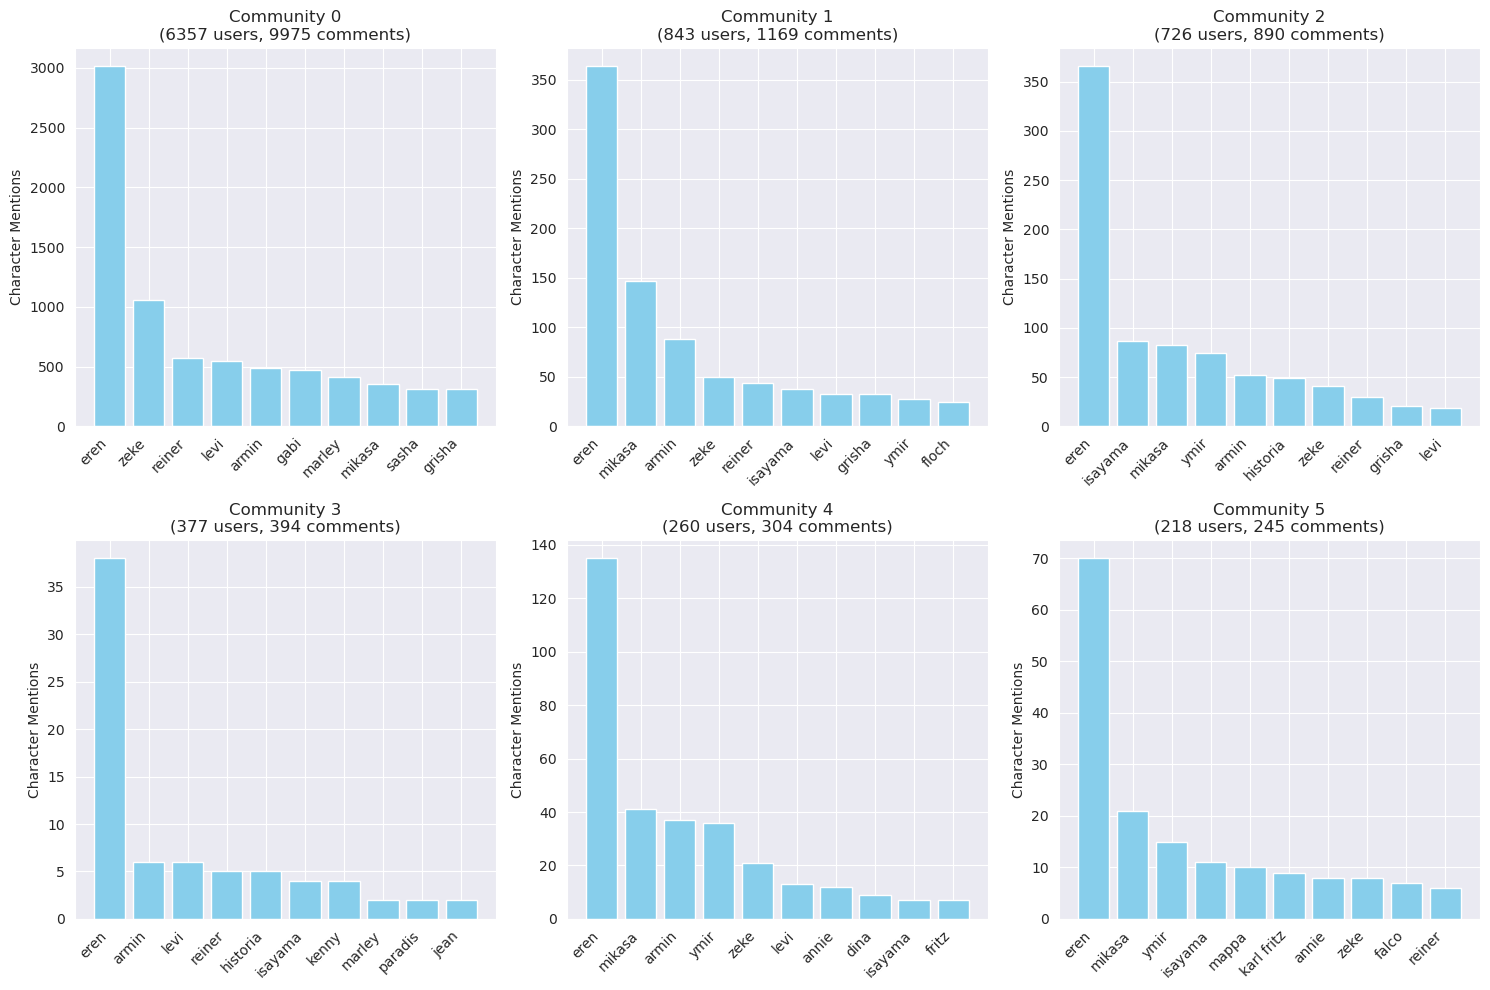

In [5]:
# Find the most active communities (by number of comments or users)
community_stats = []
for community_id, analysis in community_character_analysis.items():
    community_stats.append({
        'community_id': community_id,
        'num_users': analysis['num_users'],
        'num_comments': analysis['num_comments'],
        'unique_characters': len(analysis['character_counts']),
        'total_character_mentions': sum(analysis['character_counts'].values())
    })

community_stats_df = pd.DataFrame(community_stats)
community_stats_df = community_stats_df.sort_values('num_comments', ascending=False)

# Analyze character diversity and focus patterns
top_6_communities = community_stats_df.head(6)['community_id'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, community_id in enumerate(top_6_communities):
    analysis = community_character_analysis[community_id]
    
    if analysis['top_characters']:
        chars, counts = zip(*analysis['top_characters'])
        
        axes[i].bar(range(len(chars)), counts, color='skyblue')
        axes[i].set_title(f"Community {community_id}\n({analysis['num_users']} users, {analysis['num_comments']} comments)")
        axes[i].set_xticks(range(len(chars)))
        axes[i].set_xticklabels(chars, rotation=45, ha='right')
        axes[i].set_ylabel('Character Mentions')

plt.tight_layout()
plt.show()


Thus the cited characters change wrt the size of the community?

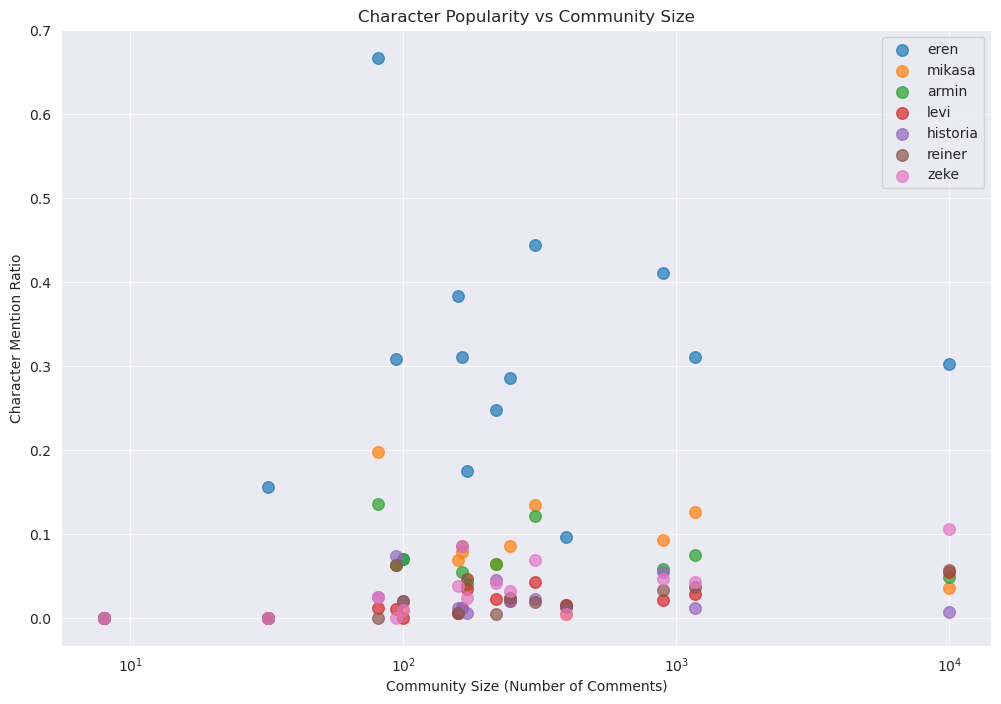

In [24]:
# Analyze if larger communities mention different characters
plt.figure(figsize=(12, 8))

for char in ['eren', 'mikasa', 'armin', 'levi', 'historia', 'reiner', 'zeke']:
    x_values = []
    y_values = []
    
    for community_id, analysis in community_character_analysis.items():
        if analysis['num_comments'] >= 5:  # Filter very small communities
            char_mentions = analysis['character_counts'].get(char, 0)
            char_ratio = char_mentions / analysis['num_comments'] if analysis['num_comments'] > 0 else 0
            
            x_values.append(analysis['num_comments'])
            y_values.append(char_ratio)
    
    plt.scatter(x_values, y_values, label=char, alpha=0.7, s=70)

plt.xlabel('Community Size (Number of Comments)')
plt.ylabel('Character Mention Ratio')
plt.title('Character Popularity vs Community Size')
plt.legend()
plt.xscale('log')
plt.grid(True, alpha=0.8)
plt.show()

It doesn't seem to be a sistematic behaviour between the character talked by communities and the sizes of such communities.

### Characters Sentiment

Now we filter the sentiment analysis from the previous notebook based on the characters presents in each comment.

In [ ]:
df_comments_sentiment_analysis = pd.read_csv('../data/comments_graph_ending_final_wscores.csv', index_col=0)

# Merge the sentiment scores with the main dataframe
# we use the score from the BERT-based sentiment analysis model
if 'model_score' not in df_comments.columns:
    df_comments = df_comments.merge(
        df_comments_sentiment_analysis[['comment_id', 'model_score']], 
        on='comment_id', 
        how='left'
    )

In [31]:
# Create a dictionary to store sentiment scores and dates for each entity
entity_sentiment_data = defaultdict(lambda: {'scores': [], 'dates': []})

entities_to_remove = [
    'mappa', 'titan', 'erens', 'paradis', 'isayama', 'marley'
]

for _, row in df_comments.iterrows():
    if pd.notna(row['model_score']) and row['entities_lowercase']:
        sentiment_score = row['model_score']
        comment_date = row['created_utc']
        
        # add sentiment and date for each entity
        for entity, tag in row['entities_lowercase']:
            if tag == 'PERSON' and entity not in entities_to_remove:
                # init the entity in the dictionary if not already present
                if entity not in entity_sentiment_data:
                    entity_sentiment_data[entity] = {'scores': [], 'dates': []}

                entity_sentiment_data[entity]['scores'].append(sentiment_score)
                entity_sentiment_data[entity]['dates'].append(comment_date)

entity_sentiment_data = dict(entity_sentiment_data)
print("Entity sentiment score statistics:")
print(f"Total entities with sentiment scores: {len(entity_sentiment_data)}")
for entity, data in list(entity_sentiment_data.items())[:10]:  # Show first 10
    scores = data['scores']
    print(f"{entity:<13}: {len(scores):>4} comments, avg sentiment: {sum(scores)/len(scores):>6.3f}")

Entity sentiment score statistics:
Total entities with sentiment scores: 1329
armin mikasa :    1 comments, avg sentiment:  2.000
eren         : 4282 comments, avg sentiment:  0.089
jean         :  241 comments, avg sentiment:  0.071
armin        :  736 comments, avg sentiment:  0.010
kenny        :   39 comments, avg sentiment:  0.333
floch        :  110 comments, avg sentiment:  0.082
historia     :  179 comments, avg sentiment: -0.006
erwins       :    6 comments, avg sentiment:  0.333
emo-eren     :    1 comments, avg sentiment:  1.000
zeke         : 1220 comments, avg sentiment: -0.053


Most Loved/Hated characters

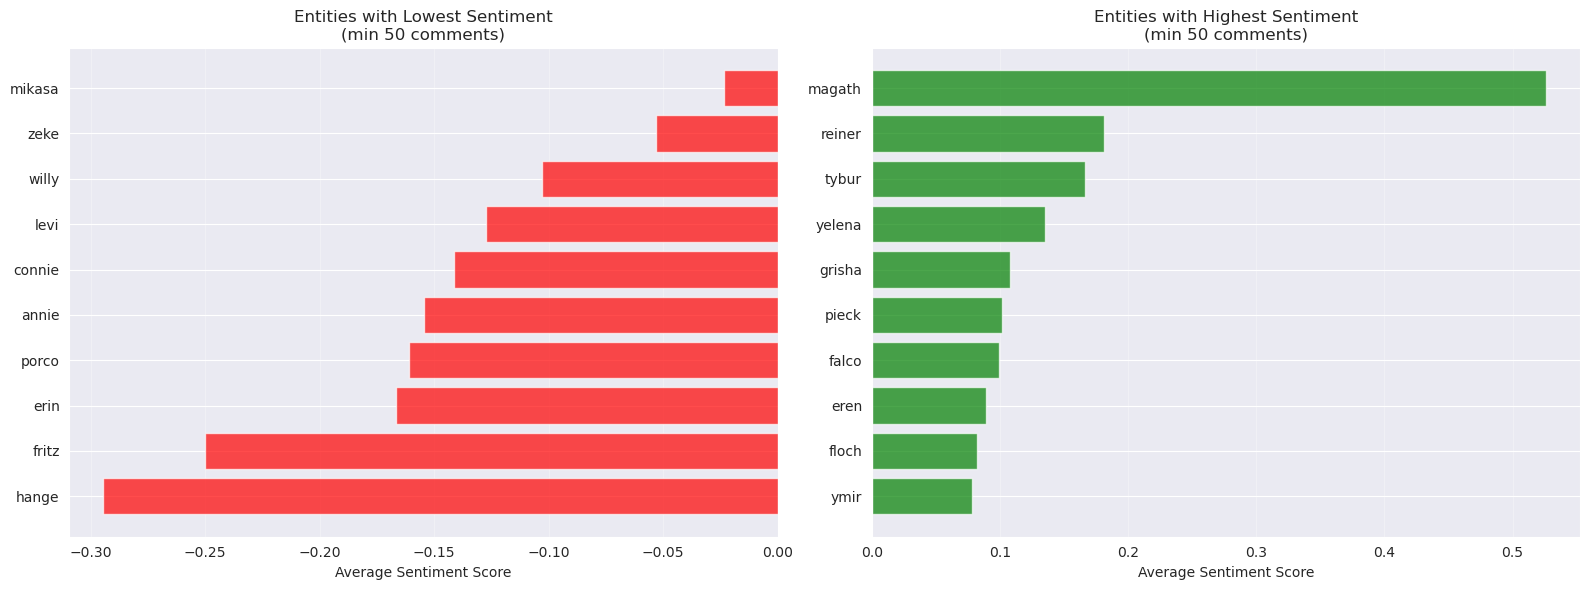

In [ ]:
# PARAMETERS
min_comments_threshold = 50 # Set threshold for minimum number of comments
n_entities = 10  # Number of top/bottom entities to show

# Filter entities with enough comments
filtered_entities = {
    entity: data for entity, data in entity_sentiment_data.items() 
    if len(data['scores']) >= min_comments_threshold
}

# Calculate average sentiment for each entity
entity_avg_sentiment = {
    entity: sum(data['scores']) / len(data['scores'])
    for entity, data in filtered_entities.items()
}

sorted_entities = sorted(entity_avg_sentiment.items(), key=lambda x: x[1])
lowest_entities = sorted_entities[:n_entities]
highest_entities = sorted_entities[-n_entities:]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

lowest_names, lowest_scores = zip(*lowest_entities)
ax1.barh(range(len(lowest_names)), lowest_scores, color='red', alpha=0.7)
ax1.set_yticks(range(len(lowest_names)))
ax1.set_yticklabels(lowest_names)
ax1.set_xlabel('Average Sentiment Score')
ax1.set_title(f'Entities with Lowest Sentiment\n(min {min_comments_threshold} comments)')
ax1.grid(axis='x', alpha=0.3)

highest_names, highest_scores = zip(*highest_entities)
ax2.barh(range(len(highest_names)), highest_scores, color='green', alpha=0.7)
ax2.set_yticks(range(len(highest_names)))
ax2.set_yticklabels(highest_names)
ax2.set_xlabel('Average Sentiment Score')
ax2.set_title(f'Entities with Highest Sentiment\n(min {min_comments_threshold} comments)')
ax2.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

Sentiment related to comments where "eren" appears over time

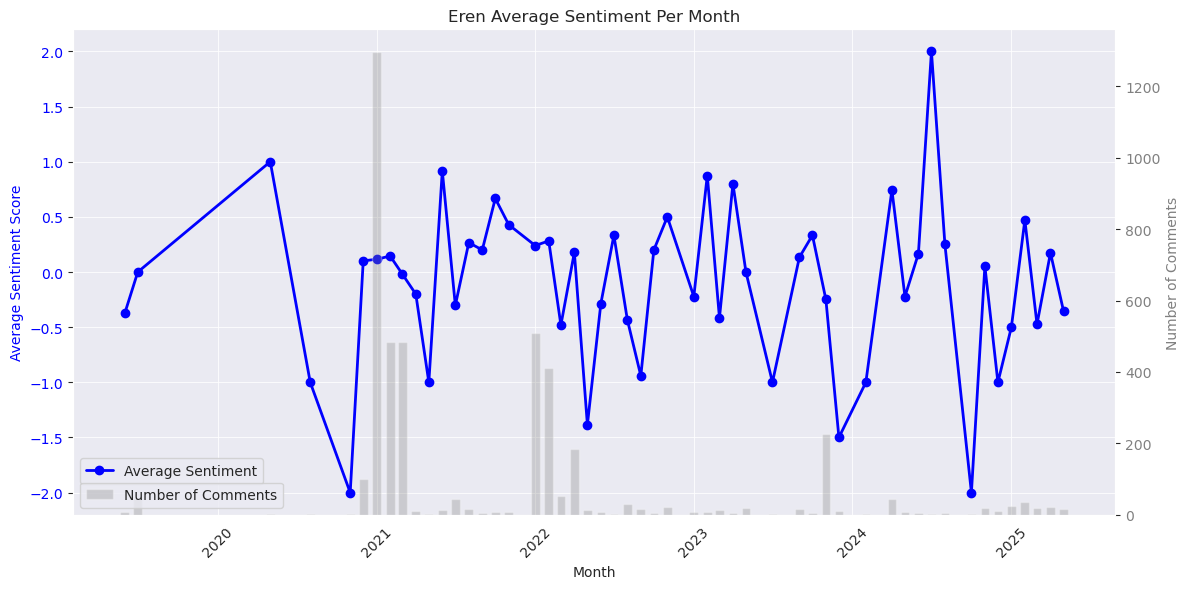

Total comments mentioning Eren: 4301
Average sentiment for Eren: 0.089
Months covered: 52


In [ ]:
# Filter data for Eren and create monthly sentiment analysis
eren_data = []
for _, row in df_comments.iterrows():
    if pd.notna(row['model_score']) and row['entities_lowercase']:
        for entity, tag in row['entities_lowercase']:
            if entity.lower() == 'eren':
                # Append the date and sentiment score for Eren
                eren_data.append({
                    'date': row['created_utc'],
                    'sentiment': row['model_score']
                })
                
# Calculate monthly average sentiment
eren_df = pd.DataFrame(eren_data)
eren_df['year_month'] = eren_df['date'].dt.to_period('M')
monthly_sentiment = eren_df.groupby('year_month')['sentiment'].agg(['mean', 'count']).reset_index()
monthly_sentiment['year_month'] = monthly_sentiment['year_month'].dt.to_timestamp()

fig, ax1 = plt.subplots(figsize=(12, 6))

# sentiment line
line = ax1.plot(monthly_sentiment['year_month'], monthly_sentiment['mean'], marker='o', linewidth=2, color='blue', label='Average Sentiment')
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Sentiment Score', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.grid(True, alpha=0.8)
ax1.tick_params(axis='x', rotation=45)

# secondary y-axis for comment counts
ax2 = ax1.twinx()
bars = ax2.bar(monthly_sentiment['year_month'], monthly_sentiment['count'], alpha=0.3, color='gray', width=20, label='Number of Comments')
ax2.set_ylabel('Number of Comments', color='gray')
ax2.tick_params(axis='y', labelcolor='gray')
ax2.grid(False)


plt.title('Eren Average Sentiment Per Month')
ax1.legend(loc='lower left', bbox_to_anchor=(0, 0.05))
ax2.legend(loc='lower left', bbox_to_anchor=(0, 0))

plt.tight_layout()
plt.show()

print(f"Total comments mentioning Eren: {len(eren_df)}")
print(f"Average sentiment for Eren: {eren_df['sentiment'].mean():.3f}")
print(f"Months covered: {len(monthly_sentiment)}")

### Characters Sentiment per Community

Instead of just analyzing the sentiment of the characters, or the most discussed characters per community, we join the two things. We are going to analyze the sentiment of the characters per community.

In [ ]:
community_character_sentiment = {}
# unique communities
communities = df_communities['infomap_community'].unique()

for community_id in communities:
    # get nodes per community
    nodes_in_comm = df_communities[df_communities['infomap_community'] == community_id]['node'].tolist()
    
    # filter comments from users in this community
    community_comments = df_comments[df_comments['parent'].isin(nodes_in_comm)]
    
    # get sentiment data for each character in this community
    character_sentiment_data = defaultdict(lambda: {'scores': [], 'count': 0})
    
    for _, row in community_comments.iterrows():
        if pd.notna(row['model_score']) and row['entities_lowercase']:
            sentiment_score = row['model_score']
            
            # add sentiment for each character apperaing in the comment
            for entity, tag in row['entities_lowercase']:
                if tag == 'PERSON' and entity not in entities_to_remove:
                    character_sentiment_data[entity]['scores'].append(sentiment_score)
                    character_sentiment_data[entity]['count'] += 1
    
    # compute avg sentiment for each character
    character_avg_sentiment = {}
    for char, data in character_sentiment_data.items():
        if data['count'] >= 5:  # minimum number of comments threshold
            character_avg_sentiment[char] = {
                'avg_sentiment': sum(data['scores']) / len(data['scores']),
                'count': data['count']
            }
    
    community_character_sentiment[community_id] = {
        'num_users': len(nodes_in_comm),
        'num_comments': len(community_comments),
        'character_sentiment': character_avg_sentiment
    }

print("Character sentiment analysis per community completed!")

Character sentiment analysis per community completed!


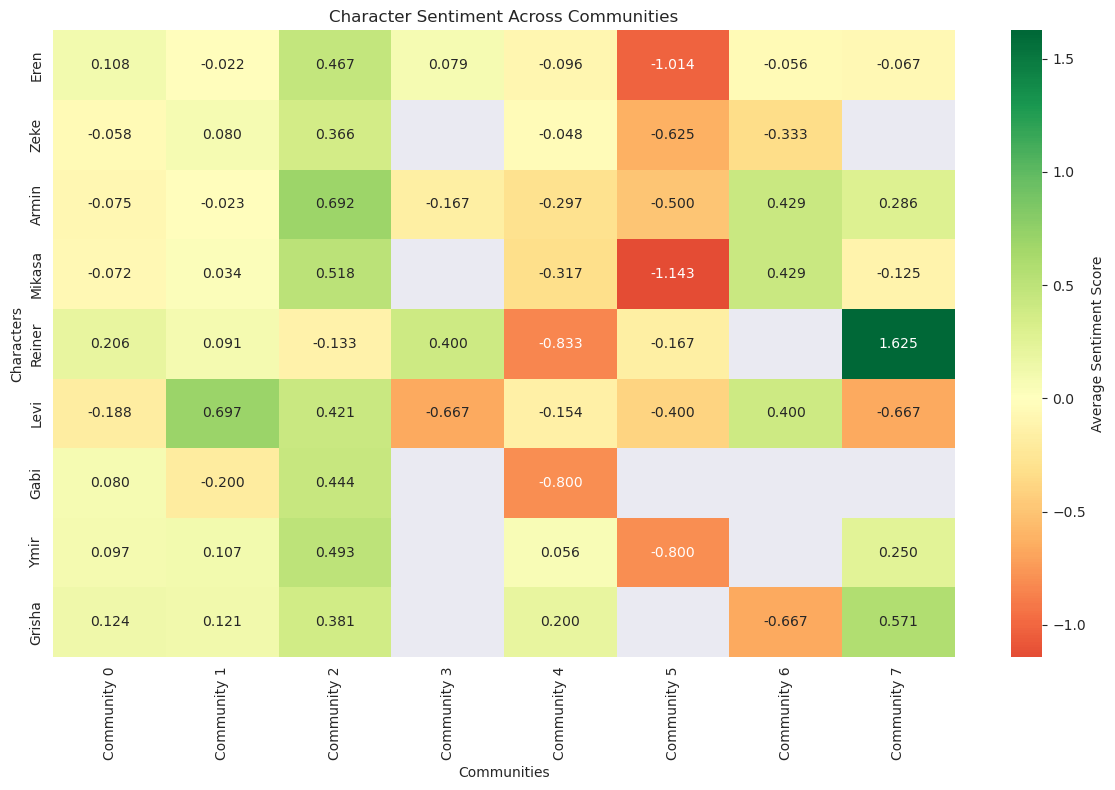

In [45]:
def create_sentiment_heatmap(top_characters=10, top_communities=8):
    """Create a heatmap of character sentiment across communities"""
    
    # most mentioned characters
    all_char_counts = Counter()
    for analysis in community_character_sentiment.values():
        for char, data in analysis['character_sentiment'].items():
            all_char_counts[char] += data['count']
    
    top_chars = [char for char, _ in all_char_counts.most_common(top_characters)]
    top_comms = community_stats_df.head(top_communities)['community_id'].tolist()
    
    # built sentiment matrix
    sentiment_matrix = []
    char_labels = []
    comm_labels = []
    
    for char in top_chars:
        row = []
        for comm_id in top_comms:
            char_data = community_character_sentiment[comm_id]['character_sentiment'].get(char)
            if char_data and char_data['count'] >= 3:
                row.append(char_data['avg_sentiment'])
            else:
                row.append(np.nan)
        
        # only include characters with data in at least half the communities
        if sum(1 for x in row if not pd.isna(x)) >= len(top_comms) // 2:
            sentiment_matrix.append(row)
            char_labels.append(char.title())
    
    comm_labels = [f"Community {comm_id}" for comm_id in top_comms]
    
    plt.figure(figsize=(12, 8))
    sentiment_df = pd.DataFrame(sentiment_matrix, index=char_labels, columns=comm_labels)
    
    sns.heatmap(sentiment_df, annot=True, fmt='.3f', cmap='RdYlGn', center=0,
                cbar_kws={'label': 'Average Sentiment Score'})
    plt.title('Character Sentiment Across Communities')
    plt.xlabel('Communities')
    plt.ylabel('Characters')
    plt.tight_layout()
    plt.grid(False)
    plt.show()
    
    return sentiment_df

sentiment_heatmap = create_sentiment_heatmap(top_characters=10, top_communities=8)

We have communities 4 and 5 that tends to be a little bit haters towards our character (the 4 in particular with *Reiner*), community 2 that instead has very positive comments, and community 7 that shows different feelings towards different characters (in particular it seems to like *Reiner*)

In [40]:
def analyze_sentiment_polarization(top_characters=10):
    """Find characters with the most polarized sentiment across communities"""
    
    character_polarization = {}
    all_char_counts = Counter()
    for analysis in community_character_sentiment.values():
        for char, data in analysis['character_sentiment'].items():
            all_char_counts[char] += data['count']
    
    top_chars = [char for char, _ in all_char_counts.most_common(top_characters)]
    
    # Calculate sentiment variance for each character across communities
    for char in top_chars:
        sentiments = []
        
        for analysis in community_character_sentiment.values():
            char_data = analysis['character_sentiment'].get(char)
            if char_data and char_data['count'] >= 3:
                sentiments.append(char_data['avg_sentiment'])
        
        if len(sentiments) >= 3:  # Need at least 3 communities for meaningful analysis
            character_polarization[char] = {
                'mean_sentiment': np.mean(sentiments),
                'std_sentiment': np.std(sentiments),
                'min_sentiment': min(sentiments),
                'max_sentiment': max(sentiments),
                'sentiment_range': max(sentiments) - min(sentiments),
                'num_communities': len(sentiments)
            }
    
    # Sort by polarization (standard deviation)
    polarized_chars = sorted(character_polarization.items(), 
                           key=lambda x: x[1]['std_sentiment'], reverse=True)
    
    print("Character Sentiment Polarization Analysis:")
    print("=" * 50)
    for char, stats in polarized_chars:
        print(f"{char.title():<10}: Range: {stats['sentiment_range']:.3f}, "
              f"Std: {stats['std_sentiment']:.3f}, "
              f"Mean: {stats['mean_sentiment']:.3f} "
              f"({stats['num_communities']} communities)")
    
    return character_polarization

polarization_analysis = analyze_sentiment_polarization()

Character Sentiment Polarization Analysis:
Reiner    : Range: 2.625, Std: 0.719, Mean: 0.053 (9 communities)
Ymir      : Range: 1.660, Std: 0.546, Mean: -0.260 (9 communities)
Mikasa    : Range: 1.661, Std: 0.500, Mean: -0.118 (11 communities)
Levi      : Range: 1.364, Std: 0.486, Mean: -0.070 (8 communities)
Gabi      : Range: 1.244, Std: 0.455, Mean: -0.119 (4 communities)
Armin     : Range: 1.643, Std: 0.451, Mean: 0.205 (12 communities)
Eren      : Range: 1.551, Std: 0.390, Mean: -0.066 (14 communities)
Grisha    : Range: 1.238, Std: 0.379, Mean: 0.071 (7 communities)
Zeke      : Range: 1.223, Std: 0.373, Mean: -0.184 (8 communities)
Sasha     : Range: 0.200, Std: 0.081, Mean: -0.087 (4 communities)


As seen also in the previous plot, *Reiner* is the most polarized characters, or you like it or you hate it.

In [61]:
# Save the dataframe with all the extracted entities and character information
df_comments.to_csv('../data/comments_graph_with_entities.csv', index=False)
print("DataFrame saved to '../data/df_comments_with_entities.csv'")

DataFrame saved to '../data/df_comments_with_entities.csv'
